In [1]:
## IMPORTS

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE, RandomOverSampler
from IPython.core.display import HTML, display
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    PrecisionRecallDisplay,
    accuracy_score,
    auc,
    precision_recall_curve,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split

display(HTML("<style>.container { width:100% !important; }</style>"))

# Import Data (https://www.kaggle.com/datasets/shashwatwork/cerebral-stroke-predictionimbalaced-dataset)

In [2]:
stroke_df = pd.read_csv("data/kaggle_stroke_dataset.csv")

In [3]:
stroke_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0


In [4]:
print("Positive Class: ", len(stroke_df[stroke_df["stroke"] == 1]))
print("Negative Class: ", len(stroke_df[stroke_df["stroke"] == 0]))
print(
    "Percent Positive Class: ",
    100 * len(stroke_df[stroke_df["stroke"] == 1]) / len(stroke_df),
    "%",
)

Positive Class:  783
Negative Class:  42617
Percent Positive Class:  1.804147465437788 %


# Pre-Process

In [5]:
stroke_df_hot = pd.get_dummies(stroke_df)
stroke_df_hot = stroke_df_hot.dropna()
X, y = stroke_df_hot.drop(["id", "stroke"], axis=1), stroke_df_hot["stroke"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)

# Build Model

In [6]:
model = GradientBoostingClassifier(random_state=1)

model.fit(X_train, y_train)
predictions = model.predict(X_test)
probabilities = model.predict_proba(X_test)[:, 1]

ans = pd.concat([X_test, y_test], axis=1)
ans["y_pred"] = predictions
ans["y_proba"] = probabilities

In [7]:
print("Precision: ", precision_score(ans["stroke"], ans["y_pred"]))
print("Recall: ", recall_score(ans["stroke"], ans["y_pred"]))
print("Accuracy: ", accuracy_score(ans["stroke"], ans["y_pred"]))
print("AUROC: ", roc_auc_score(ans["stroke"], ans["y_proba"]))

Precision:  0.0
Recall:  0.0
Accuracy:  0.9846098265895954
AUROC:  0.839958732960278


# Vanilla Oversample

In [8]:
def randomOversampling(data, response, ratio=None):

    """
    Helper function that performs random over sampling of minority class
    data (Pandas DataFrame): Training data containing feature(s) and a response column

    response (String): Name of response variable column in data
    """

    X = data.drop(response, axis=1)
    Y = data[response]
    os = RandomOverSampler(random_state=42)

    X_os, Y_os = os.fit_resample(X, Y)

    return pd.concat([X_os, Y_os], axis=1)

In [9]:
stroke_df_over = randomOversampling(pd.concat([X_train, y_train], axis=1), "stroke")

In [10]:
model = GradientBoostingClassifier(random_state=1)
model.fit(stroke_df_over.drop("stroke", axis=1), stroke_df_over["stroke"])
predictions = model.predict(X_test)
probabilities = model.predict_proba(X_test)[:, 1]

ans_over = pd.concat([X_test, y_test], axis=1)
ans_over["y_pred"] = predictions
ans_over["y_proba"] = probabilities

In [11]:
print("Precision: ", precision_score(ans_over["stroke"], ans_over["y_pred"]))
print("Recall: ", recall_score(ans_over["stroke"], ans_over["y_pred"]))
print("Accuracy: ", accuracy_score(ans_over["stroke"], ans_over["y_pred"]))
print("AUROC: ", roc_auc_score(ans_over["stroke"], ans_over["y_proba"]))

Precision:  0.047238855622089154
Recall:  0.6995073891625616
Accuracy:  0.7886560693641619
AUROC:  0.8338044388798802


# SMOTE

In [12]:
def SMOTEoversampling(data, response):

    X = data.drop(response, axis=1)
    Y = data[response]

    smote = SMOTE(random_state=42)
    X_smote, Y_smote = smote.fit_resample(X, Y)

    return pd.concat([X_smote, Y_smote], axis=1)

In [13]:
stroke_df_smote = SMOTEoversampling(pd.concat([X_train, y_train], axis=1), "stroke")

In [14]:
model = GradientBoostingClassifier(random_state=1)

model.fit(stroke_df_smote.drop("stroke", axis=1), stroke_df_smote["stroke"])
predictions = model.predict(X_test)
probabilities = model.predict_proba(X_test)[:, 1]

ans_smote = pd.concat([X_test, y_test], axis=1)
ans_smote["y_pred"] = predictions
ans_smote["y_proba"] = probabilities

In [15]:
print("Precision: ", precision_score(ans_smote["stroke"], ans_smote["y_pred"]))
print("Recall: ", recall_score(ans_smote["stroke"], ans_smote["y_pred"]))
print("Accuracy: ", accuracy_score(ans_smote["stroke"], ans_smote["y_pred"]))
print("AUROC: ", roc_auc_score(ans_smote["stroke"], ans_smote["y_proba"]))

Precision:  0.056666666666666664
Recall:  0.08374384236453201
Accuracy:  0.9661127167630058
AUROC:  0.7856554050466151


# Get Imbalanced Metrics

In [16]:
from aequilibrium.balance import Balance
from aequilibrium.dataset import DataSet
from aequilibrium.model import Model
from aequilibrium.results import Results
from aequilibrium.utils.api_wrapper import (
    get_best_results,
    train_and_evaluate,
    train_models,
)
from aequilibrium.visualize import Visualize

# Original

In [17]:
y_true = "stroke"
y_pred = "y_pred"
y_proba = "y_proba"

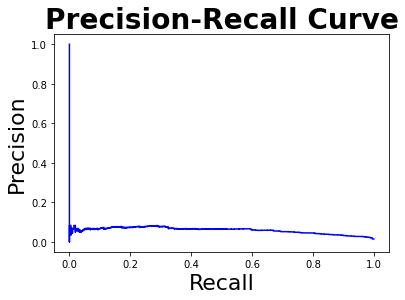

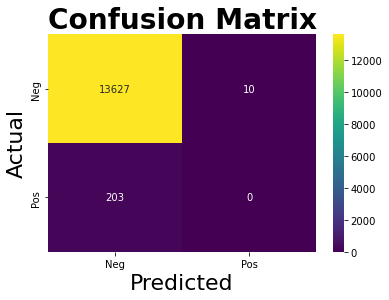

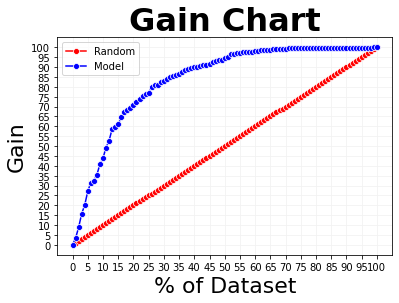

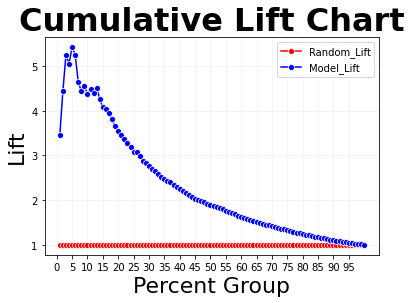

In [18]:
results_class = Results(ans[y_true], ans[y_pred], ans[y_proba])
results_viz = Visualize(results_class, num_decimals=2)
measure_df = results_viz.complete_evaluation(save_dir="my_plots")

In [19]:
measure_df[measure_df["percentile"].isin([0.01, 0.03, 0.05, 0.10, 0.20, 0.50, 1.0])][
    [
        "percentile",
        "row_count",
        "pos_count",
        "perc_random_events",
        "perc_actual_events",
        "Model_Lift",
    ]
]

,percentile,row_count,pos_count,perc_random_events,perc_actual_events,Model_Lift
0,0.01,139,7,1.0,3.448276,3.448276
2,0.03,416,32,3.0,15.763547,5.254516
4,0.05,692,55,5.0,27.093596,5.418719
19,0.20,2768,144,20.0,70.935961,3.546798
49,0.50,6920,192,50.0,94.581281,1.891626
99,1.00,13840,203,100.0,100.000000,1.000000


# Vanilla Oversample

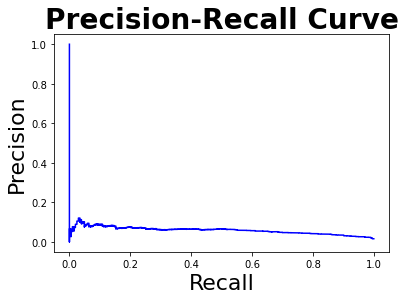

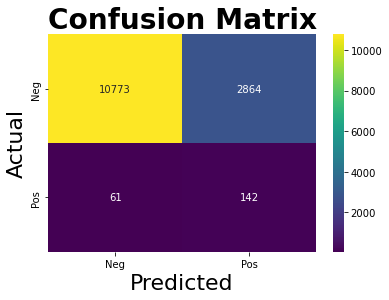

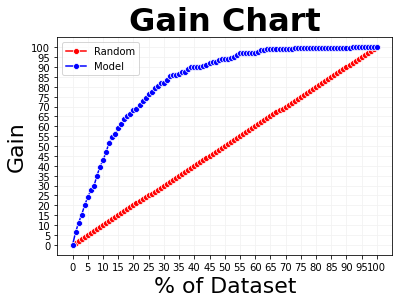

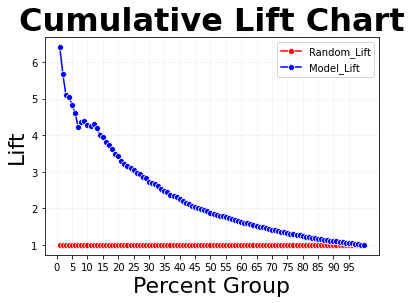

In [20]:
y_true = "stroke"
y_pred = "y_pred"
y_proba = "y_proba"

over_results_class = Results(ans_over[y_true], ans_over[y_pred], ans_over[y_proba])
over_results_viz = Visualize(over_results_class, num_decimals=2)
over_measure_df = over_results_viz.complete_evaluation(save_dir="over_plots")

In [21]:
over_measure_df[
    over_measure_df["percentile"].isin([0.01, 0.03, 0.05, 0.10, 0.20, 0.50, 1.0])
][
    [
        "percentile",
        "row_count",
        "pos_count",
        "perc_random_events",
        "perc_actual_events",
        "Model_Lift",
    ]
]

,percentile,row_count,pos_count,perc_random_events,perc_actual_events,Model_Lift
0,0.01,139,13,1.0,6.403941,6.403941
2,0.03,416,31,3.0,15.270936,5.090312
4,0.05,692,49,5.0,24.137931,4.827586
19,0.20,2768,139,20.0,68.472906,3.423645
49,0.50,6920,191,50.0,94.088670,1.881773
99,1.00,13840,203,100.0,100.000000,1.000000


# SMOTE

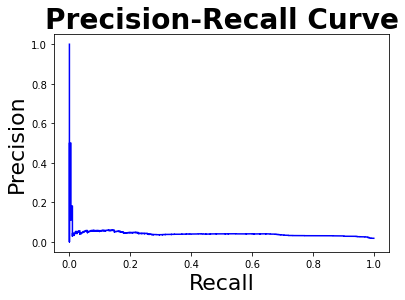

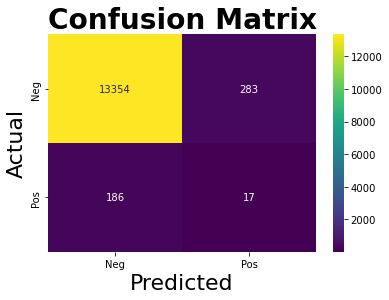

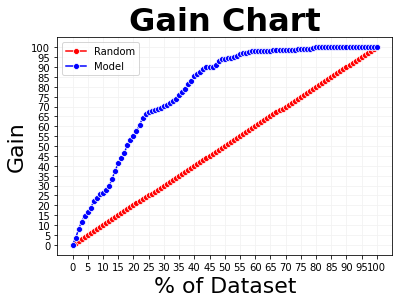

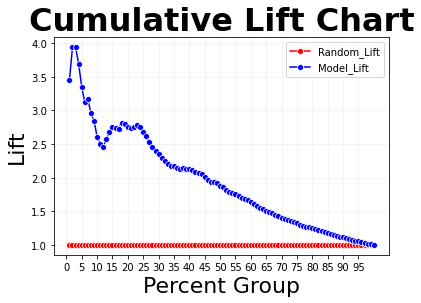

In [22]:
y_true = "stroke"
y_pred = "y_pred"
y_proba = "y_proba"

smote_results_class = Results(ans_smote[y_true], ans_smote[y_pred], ans_smote[y_proba])
smote_results_viz = Visualize(smote_results_class, num_decimals=2)
smote_measure_df = smote_results_viz.complete_evaluation(save_dir="smote_plots")

In [23]:
smote_measure_df[
    smote_measure_df["percentile"].isin([0.01, 0.03, 0.05, 0.10, 0.20, 0.50, 1.0])
][
    [
        "percentile",
        "row_count",
        "pos_count",
        "perc_random_events",
        "perc_actual_events",
        "Model_Lift",
    ]
]

,percentile,row_count,pos_count,perc_random_events,perc_actual_events,Model_Lift
0,0.01,139,7,1.0,3.448276,3.448276
2,0.03,416,24,3.0,11.822660,3.940887
4,0.05,692,34,5.0,16.748768,3.349754
19,0.20,2768,112,20.0,55.172414,2.758621
49,0.50,6920,191,50.0,94.088670,1.881773
99,1.00,13840,203,100.0,100.000000,1.000000


# Business Case Example

In [24]:
intervene_df = measure_df[measure_df["percentile"].isin([0.03])][
    [
        "percentile",
        "row_count",
        "pos_count",
        "perc_random_events",
        "perc_actual_events",
        "Model_Lift",
    ]
]
intervene_df

,percentile,row_count,pos_count,perc_random_events,perc_actual_events,Model_Lift
2,0.03,416,32,3.0,15.763547,5.254516


In [25]:
reach_rate = 0.30
cost_of_call = 2

intervene_df["TotalNum_Called"] = intervene_df["row_count"]
intervene_df["TotalNum_Reached"] = round(intervene_df["row_count"] * reach_rate)
intervene_df["TotalCost"] = intervene_df["TotalNum_Called"] * cost_of_call

intervene_df

,percentile,row_count,pos_count,perc_random_events,perc_actual_events,Model_Lift,TotalNum_Called,TotalNum_Reached,TotalCost
2,0.03,416,32,3.0,15.763547,5.254516,416,125.0,832


In [26]:
participation_rate = 1.00
stroke_reduction_rate = 0.3

intervene_df["TotalNum_Participate"] = round(
    intervene_df["TotalNum_Reached"] * participation_rate
)
intervene_df["TotalNum_Participate_wStroke"] = round(
    intervene_df["TotalNum_Participate"]
    * (intervene_df["pos_count"] / intervene_df["row_count"])
)
intervene_df["TotalStrokesReduced"] = round(
    intervene_df["TotalNum_Participate_wStroke"] * stroke_reduction_rate
)

intervene_df

,percentile,row_count,pos_count,perc_random_events,perc_actual_events,Model_Lift,TotalNum_Called,TotalNum_Reached,TotalCost,TotalNum_Participate,TotalNum_Participate_wStroke,TotalStrokesReduced
2,0.03,416,32,3.0,15.763547,5.254516,416,125.0,832,125.0,10.0,3.0
